In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

In [2]:
from langgraph.graph import StateGraph, END 
from typing import TypedDict, List, Any
from langgraph.checkpoint.sqlite import SqliteSaver 
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

from prompts import *

memory = SqliteSaver.from_conn_string(":memory:")

MAX_REVIEW_COUNT = 2

In [3]:
class AgentState(TypedDict):
    query: str 
    definition: str 
    decomposed_steps: List[str]
    solved_steps: List[str]
    step_history: List[Any]
    completed_step: int
    review_count: int

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class Steps(BaseModel):
    steps: List[str]

# class StepPlan(BaseModel):
#     response: str = Field(
#         "Either contains solution of the step if calculator is not needed or" \
#             " includes the query for the calculator"
#     )
#     use_calculator: bool = Field(
#         "defines whether to use calculator or the solution is already finished"
#     )

class StepPlan(BaseModel):
    response: str 
    use_calculator: bool
    review_steps: bool

In [5]:
def problem_definer_node(state: AgentState):
    messages = [
        SystemMessage(content=PROBLEM_DEFINER_PROMPT),
        HumanMessage(content=state['query'])
    ]
    response = llm.invoke(messages)
    return {
        "definition": response.content,
        "review_count": 0
    }

In [6]:
def problem_decomposer_node(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=Steps)
    
    chain = llm | parser
    system_message = f"{PROBLEM_DECOMPOSER_PROMPT}\n\nFormat Instructions: {parser.get_format_instructions()}"
    
    messages = [
        SystemMessage(content=system_message),
        HumanMessage(content=state['definition'])
    ]
    
    steps = chain.invoke(messages)
    return {
        "decomposed_steps": steps.steps, 
        "completed_steps": 0, 
        "step_history": [], 
        "solved_steps": []
    }

In [7]:
def step_iterator(state: AgentState):
    print("Steps completed - ", state['completed_step'])
    if (state['completed_step'] or 0) >= len(state['decomposed_steps']):
        return "refine_steps"
    return "generate_step"

In [8]:
from langchain_core.exceptions import OutputParserException

def step_generator(state: AgentState):
    solved_steps = state['solved_steps'] or []
    step_count = state['completed_step'] or 0
    messages = state['step_history'] or []
    
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    chain = llm | parser
    
    if len(messages) == 0:
        system_message = STEP_GENERATOR_PROMPT.format(format_instructions=parser.get_format_instructions())
        content = "\n\n".join(solved_steps)
        human_content = f"Original problem definition: {state['query']}. This is the solution so far: {content}\n\n and this is the description for next step: {state['decomposed_steps'][step_count]}"
        
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=human_content)
        ]
    
    retry = 0
    while True:
        try:
            response = chain.invoke(messages)
            break
        except OutputParserException as e:
            retry += 1
            if retry > 2:
                raise e
            continue
    messages.append(AIMessage(content=response.json()))
    
    return {
        "step_history": messages
    }

In [9]:
def step_tool_decider(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    last_response = state['step_history'][-1]
    last_response = parser.parse(last_response.content)
    
    if last_response.use_calculator:
        return "calculator"
    if last_response.review_steps:
        review_count = state['review_count'] or 0
        if review_count < MAX_REVIEW_COUNT:
            review_count += 1
            return "reset_steps"
    return "update_steps"

In [10]:
def review_steps(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    last_response = state['step_history'][-1]
    last_response = parser.parse(last_response.content)
    
    solved_steps = state['solved_steps'] or []
    content = "\n\n".join(solved_steps)
    content += last_response.response
    
    content = "Problem Definition:\n" + state['definition'] + "\n\nSTEPS AND FEEDBACK:\n" + content
    
    messages = [
        SystemMessage(content=STEPS_REVIEW_PROMPT),
        HumanMessage(content=content)
    ]
    
    response = llm.invoke(messages)
    
    return {
        "definition": response.content
    }

In [11]:
def update_steps(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    last_response = state['step_history'][-1]
    last_response = parser.parse(last_response.content)
    
    step_count = state['completed_step'] or 0
    step_count += 1
    solved_steps = state['solved_steps'] or []
    solved_steps.append(last_response.response)
    
    return {
        "completed_step": step_count, 
        "solved_steps": solved_steps, 
        "step_history": []
    }

In [12]:
from langchain_community.utilities.wolfram_alpha import WolframAlphaAPIWrapper

def calculator(state: AgentState):
    parser = PydanticOutputParser(pydantic_object=StepPlan)
    last_response = state['step_history'][-1]
    last_response = parser.parse(last_response.content)
    
    wolfram = WolframAlphaAPIWrapper()
    response = wolfram.run(last_response.response)
    human_content = f"With calculator response: {response}. Generate the whole solution."
    messages = state['step_history']
    messages.append(HumanMessage(
        content=human_content
    ))
    
    return {
        "step_history": messages
    }

In [13]:
def refiner(state: AgentState):
    solved_steps = state['solved_steps'] or []
    content = "\n\n".join(solved_steps)
    
    query = state['query']
    human_content = f"Problem Definition: {query}\n\nSolved Steps: {content}"
    
    messages = [
        SystemMessage(content=REFINER_PROMPT),
        HumanMessage(content=human_content)
    ]
    
    response = llm.invoke(messages)
    solved_steps.append(response.content)
    return {
        "solved_steps": solved_steps
    }

In [14]:
# def step_generator(state: AgentState):
#     solved_steps = state['solved_steps'] or []
#     step_count = state.get("completed_steps", 0)
#     while step_count != len(state['decomposed_steps']):
#         content = "\n\n".join(solved_steps)
#         human_content = f"Original problem definition: {state['query']}. This is the solution so far: {content}\n\n and this is the description for next step: {state['decomposed_steps'][step_count]}"
        
#         messages = [
#             SystemMessage(content=STEP_GENERATOR_PROMPT),
#             HumanMessage(content=human_content)
#         ]
#         response = llm.invoke(messages)
#         solved_steps.append(response.content)
#         step_count += 1
    
#     return {
#         "solved_steps": solved_steps, 
#         "completed_steps": step_count
#     }

In [15]:
builder = StateGraph(AgentState)

In [16]:
builder.add_node("definer", problem_definer_node)
builder.add_node("decomposer", problem_decomposer_node)
builder.add_node("solver", step_generator)
builder.add_node("calculator", calculator)
builder.add_node("steps_updater", update_steps)
builder.add_node("steps_reviewer", review_steps)
builder.add_node("response_refiner", refiner)
builder.add_node("gateway_node", lambda x:x)

In [17]:
builder.set_entry_point("definer")

In [18]:
builder.add_edge("definer", "decomposer")
builder.add_edge("decomposer", "gateway_node")
builder.add_edge("steps_updater", "gateway_node")
builder.add_edge("calculator", "solver")
builder.add_edge("steps_reviewer", "decomposer")
builder.add_edge("response_refiner", END)

In [19]:
builder.add_conditional_edges(
    "gateway_node", 
    step_iterator, 
    {
        "refine_steps": "response_refiner", 
        "generate_step": "solver"
    }
)
builder.add_conditional_edges(
    "solver", 
    step_tool_decider, 
    {
        "calculator": "calculator",
        "update_steps": "steps_updater",
        "reset_steps": "steps_reviewer"
    }
)

In [20]:
graph = builder.compile(checkpointer=memory)

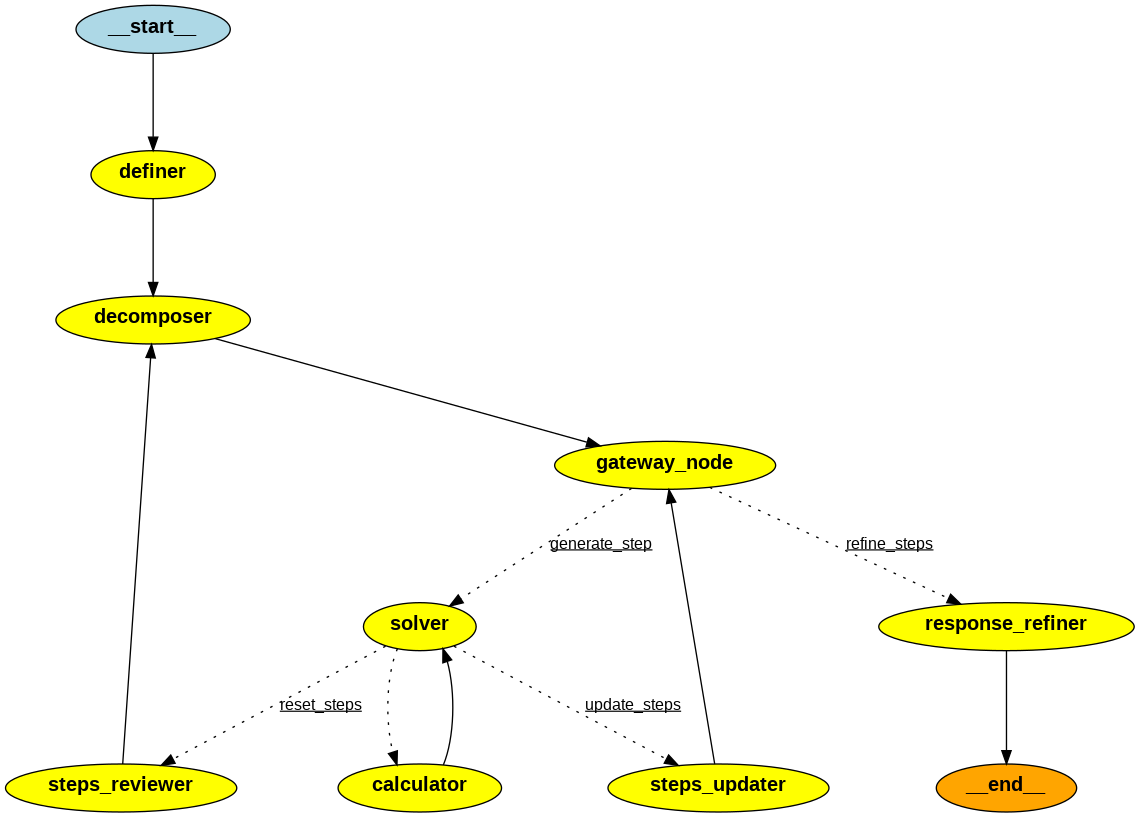

In [21]:
from IPython.display import Image 

Image(graph.get_graph().draw_png())

In [22]:
thread = {"configurable": {"thread_id": 2}}

query = """ 
sin^2(x) + cos^2(x) = 1, prove that
"""

response = graph.invoke({"query": query}, thread)
# for output in graph.stream({"query": query}, thread, stream_mode="updates"):
#     # stream() yields dictionaries with output keyed by node name
#     for key, value in output.items():
#         print(f"Output from node '{key}':")
#         print("---")
#         print(value)
#     print("\n---\n")

Steps completed -  None
Steps completed -  1


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


Steps completed -  2
Steps completed -  3
Steps completed -  4


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


Steps completed -  5
Steps completed -  6


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


In [23]:
print("\n\n".join(response['solved_steps']))

Awaiting user input: The problem statement is incomplete. Please provide the missing information, specifically what needs to be proven, solved, or simplified using the Pythagorean identity (sin²(x) + cos²(x) = 1).

Awaiting user input: The problem statement is incomplete. Please provide the missing information, specifically what needs to be proven, solved, or simplified using the Pythagorean identity (sin²(x) + cos²(x) = 1).

Okay, I understand that to proceed, we need a clear objective for this problem.  The given information is the standard Pythagorean trigonometric identity:  sin²(x) + cos²(x) = 1.  

Please provide the complete problem statement so I can guide you through the solution process. What are we trying to prove, solve, or simplify using this identity?

Okay, I understand that to proceed, we need a clear objective for this problem.  The given information is the standard Pythagorean trigonometric identity:  sin²(x) + cos²(x) = 1.  

Please provide the complete problem state

In [24]:
response['decomposed_steps']

['**Awaiting user input:** The problem statement is incomplete. Please provide the missing information, specifically what needs to be proven, solved, or simplified using the Pythagorean identity (sin²(x) + cos²(x) = 1).',
 '**Once the goal is clear, I can proceed with the following:**',
 '1. **Analyze the complete problem statement.**',
 '2. **Identify the relevant trigonometric concepts and techniques** based on the goal (e.g., proving identities, solving equations, simplifying expressions).',
 '3. **Decompose the problem into smaller sub-problems**, using the Pythagorean identity and other trigonometric relationships as needed.',
 '4. **Provide a step-by-step solution** to each sub-problem, ultimately achieving the overall goal.']

In [25]:
print(response['definition'])

This problem statement lacks sufficient information to be solved. The user provides the Pythagorean identity (sin²(x) + cos²(x) = 1) but doesn't specify what needs to be proven.  

**To formulate a solvable problem statement, we need a clear goal.** 

For example, the user could ask to:

* **Prove an identity:** "Given sin²(x) + cos²(x) = 1, prove that tan²(x) + 1 = sec²(x)."
* **Solve an equation:** "Given sin²(x) + cos²(x) = 1, solve for x in the equation 2sin²(x) - cos²(x) = 1."
* **Simplify an expression:** "Given sin²(x) + cos²(x) = 1, simplify the expression (1 - cos²(x))/sin(x)." 

**Please provide the missing information, specifically what needs to be proven, solved, or simplified using the given identity.** 

